### Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import gc
import datetime
import itertools
import re
tf.random.set_seed(123)

import time

In [3]:
cd /content/drive/MyDrive/AISIA/Jira recommendation/

/content/drive/MyDrive/AISIA/Jira recommendation


# Load dataset

In [4]:
def encode_graph(row):
  new_row = []
  for i in row:
    if i==0:
      new_row.append([1,0])
    else:
      new_row.append([0,1])
  return new_row

In [5]:
def load_project(project_name):
  # Attributes
  df = pd.read_csv('data/{}/attribute_preprocess.csv'.format(project_name))
  df = df.fillna('')
  # Graph
  graph = pd.read_csv('data/{}/graph.csv'.format(project_name), delimiter=',')
  graph = graph.apply(encode_graph)
  graph = graph.values
  return df, graph

# Get features

In [6]:
def get_textual_features(df, choose_feature_string):
  # Load title/description/summary vectors
  loading_path = 'embedding/fasttext/post/{}/'.format(project_name)
  path = loading_path
  all_textual_vectors = np.load(loading_path + 'textual_features.npy')
  # for feature in choose_feature_string:
  #   print('Loading',feature)
  #   path+=(feature+'_')
  # path = path[:-1]+'/'
  # vectors = np.load(path+'textual_features.npy')

  return all_textual_vectors

In [7]:
def get_time_features(df):
  createds = pd.to_datetime(df['created'])
  updateds = pd.to_datetime(df['updated'])
  return [createds, updateds]

# Split data

In [8]:
def split_data(createds, graph, time_split):
  # Get date to split data
  x = createds[0]
  check_date = x + abs(datetime.timedelta(time_split))

  train_nodes = []
  test_nodes = []

  for i in range(0, len(createds)):
    if createds[i]<=check_date:
      train_nodes.append(i)
    else:
      test_nodes.append(i) 

  # Delete all lonely nodes in test
  c = 0
  new_test_node = []
  for i in test_nodes:
    t = True
    for j in graph[i,:]:
      if j[1]!=0: # has linked
        t = False
    if not t:
      c+=1
      new_test_node.append(i)

  test_nodes = new_test_node
  all_nodes = train_nodes + test_nodes

  return train_nodes, test_nodes, all_nodes

### Pairing

In [9]:
def get_pairs(graph, list_nodes_1, list_nodes_2):
  # Get size
  size_1 = len(list_nodes_1)
  size_2 = len(list_nodes_2)

  # Get index of pairs
  pairs = np.empty((size_1*size_2,2))
  # Get label
  labels = np.empty((size_1*size_2,2))

  c=0
  for i in tqdm(range(0, size_1)):
    for j in range(0, size_2):
      u = list_nodes_1[i]
      v = list_nodes_2[j]
      if u!=v:
        # Get index of pairs
        pairs[c] = [u,v]
        # Get label
        labels[c] = graph[u][v]
        c+=1

  pairs = pairs[:c]
  labels = labels[:c]
  return pairs, labels

# Get training dataset

In [10]:
def create_pair_dataset(pairs, labels):
  # Get data
  # Index of pairs which have link
  link_data_index = np.array([i for i in range(len(pairs)) if labels[i][0]==0])

  # Index of pairs which don't have link
  non_link_data_index = np.array([i for i in range(len(pairs)) if labels[i][0]==1])

  return link_data_index, non_link_data_index

def get_separated_data_pairs(input, add_feature = None):
  pairs, labels, createds, updateds = input

  link_data_index, non_link_data_index = create_pair_dataset(pairs, labels)
  
  link_data = []
  non_link_data = []
  print('Get training data pairs')
  # Get link_data
  for index in tqdm(link_data_index):
      p = pairs[index]
      u = int(p[0])
      v = int(p[1])
      link_data.append([u, v])
      
  # Get non_link_data
  for index in tqdm(non_link_data_index):
      p = pairs[index]
      u = int(p[0])
      v = int(p[1])
      non_link_data.append([u, v])
  
  if add_feature != None:
    print('Get time features!')
    link_other_features = []
    non_link_other_features = []
    
    # Get link_data
    for index in tqdm(link_data_index):
        p = pairs[index]
        u = int(p[0])
        v = int(p[1])

        cre_u = createds[u]
        
        if add_feature==1: # Only cre-cre feature
          cre_v = createds[v]
          cre_cre = abs((cre_u - cre_v).days)
          link_other_features.append([cre_cre])
        else:
          if add_feature==2: # Only cre-up feature
            update_v = updateds[v]
            cre_up = abs((cre_u - update_v).days)
            link_other_features.append([cre_up])
          else: # Add all time features (cre_cre, cre_up)
            cre_v = createds[v]
            cre_cre = abs((cre_u - cre_v).days)
            update_v = updateds[v]
            cre_up = abs((cre_u - update_v).days)
            link_other_features.append([cre_cre, cre_up])


    # Get non_link_data
    for index in tqdm(non_link_data_index):
        p = pairs[index]
        u = int(p[0])
        v = int(p[1])
        
        cre_u = createds[u]
        
        if add_feature==1:
          cre_v = createds[v]
          cre_cre = abs((cre_u - cre_v).days)
          non_link_other_features.append([cre_cre])
        else:
          if add_feature==2:
            update_v = updateds[v]
            cre_up = abs((cre_u - update_v).days)
            non_link_other_features.append([cre_up])
          else:
            cre_v = createds[v]
            cre_cre = abs((cre_u - cre_v).days)
            update_v = updateds[v]
            cre_up = abs((cre_u - update_v).days)
            non_link_other_features.append([cre_cre, cre_up])

    return link_data, non_link_data, link_other_features, non_link_other_features
    
  return link_data, non_link_data

In [11]:
def generate_input(config_generator, train_input):
  batch_size, mul, add_feature = config_generator
  all_textual_vectors, link_data, non_link_data, link_other_features, non_link_other_features = train_input
  while True:
    each_size = int(batch_size/2)
    
    # Shuffle index of link data
    shuffle_index = [index for index in np.random.choice(len(link_data), len(link_data), replace=False)]
    link_data = [link_data[index] for index in shuffle_index]
    
    if add_feature!=None:
      link_other_features = [link_other_features[index] for index in shuffle_index]

    for iter in range(int(len(link_data)/each_size)):
        # Split data by batch size and randomly select non_link_data: 1/2 for link data, 1/2 for unlink data
        
        # Get index
        link_index = np.array(range(iter*each_size, (iter+1)*each_size))
        non_link_index = np.array([index for index in np.random.choice(len(non_link_data), each_size*mul, replace=False)])
        
        link_X = [link_data[i] for i in link_index]
        non_link_X = [non_link_data[i] for i in non_link_index]
        
        # Create X by tokenizing and padding X
        X = np.array(link_X + non_link_X)
        padded_A = all_textual_vectors[X[:,0]]
        padded_B = all_textual_vectors[X[:,1]]

        # Create label y
        link_y = np.vstack([np.zeros(len(link_X)), np.ones(len(link_X))]).T
        non_link_y = np.vstack([np.ones(len(link_X)), np.zeros(len(link_X))]).T
        y = np.concatenate([link_y, non_link_y])
                
        index = np.random.choice(batch_size, batch_size, replace=False)
        if add_feature!=None:
          # Create other features
          link_other_X = np.array([link_other_features[i] for i in link_index])
          non_link_other_X = np.array([non_link_other_features[i] for i in non_link_index])
          other_features = np.concatenate([link_other_X, non_link_other_X])
          yield [padded_A[index], padded_B[index], other_features[index]], y[index]
        else:
          yield [padded_A[index], padded_B[index]], y[index]
  return 0

## Model

In [12]:
def return_model(input_init, add_feature):
  value_maxlen, number_units, lr, l = input_init
  inputs_A = tf.keras.Input(shape=(value_maxlen, 300), name="input_a")
  inputs_B = tf.keras.Input(shape=(value_maxlen, 300), name="input_b")

  if add_feature==1 or add_feature==2:
    inputs_C = tf.keras.Input(shape=(1), name="input_c")
  else:
    inputs_C = tf.keras.Input(shape=(2), name="input_c")

  # Deep Learning model's structure
  gru_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(number_units, name="gru"))
  flatten_layer = tf.keras.layers.Flatten(name="flatten")
  dense_1_layer = tf.keras.layers.Dense(number_units, activation="relu", name="dense_1")
  output_layer = tf.keras.layers.Dense(2, activation="softmax", name="dense_output")

  # rnn
  gru_A = gru_layer(inputs_A)
  gru_B = gru_layer(inputs_B)

  if add_feature==None:
  
    # Concat two embedded inputs
    X = tf.concat([flatten_layer(gru_A), flatten_layer(gru_B)], axis=1)
  
    dense_1_X = dense_1_layer(X)
  
    outputs = output_layer(dense_1_X)
  
    model = tf.keras.Model(inputs=[inputs_A, inputs_B], outputs=outputs)
  
  else:
  
    # Concat two embedded inputs
    X = tf.concat([flatten_layer(gru_A), flatten_layer(gru_B), inputs_C], axis=1)
  
    dense_1_X = dense_1_layer(X)
  
    outputs = output_layer(dense_1_X)
  
    model = tf.keras.Model(inputs=[inputs_A, inputs_B, inputs_C], outputs=outputs)
  
  model.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss=l, metrics=["categorical_accuracy"])
  model.summary()

  return model

In [13]:
def train_model(model_params, init_input, train_input):
  steps_per_epoch, epochs, batch_size, add_feature = model_params
  model_path, value_maxlen, model, all_textual_vectors = init_input
  links_train, non_links_train, links_other_features_train, non_links_other_features_train = train_input
  
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = model_path, save_best_only=True, save_weights_only=True)
  
  # Config generator
  batch_size = 64
  mul = 3
  config_generator = (batch_size, mul, add_feature)
  train_input = all_textual_vectors, links_train, non_links_train, links_other_features_train, non_links_other_features_train
  history = model.fit(generate_input(config_generator, train_input), 
              steps_per_epoch=steps_per_epoch, 
              epochs=epochs,
              shuffle=False,
              callbacks=[model_checkpoint_callback],
              verbose = 1)
  return history

## Recommend

In [14]:
def model_predict(init_input, data_test, labels_test, other_features):
  value_maxlen, model, all_textual_vectors = init_input
  y_s = np.empty((2,2))
  pred_s = np.empty((2,2))

  each_size = len(data_test) #all dataset
  
  t = 0
  while t<each_size:
    if t+2048 < each_size:
      data_X = data_test[t:t+2048]
    else:
      data_X = data_test[t:]

    X = np.array(data_X)
    padded_A = all_textual_vectors[X[:,0]]
    padded_B = all_textual_vectors[X[:,1]]
    
    # Create label y
    if t+2048 < each_size:
      y = labels_test[t:t+2048]
    else:
      y = labels_test[t:]

    if type(other_features) is np.ndarray:
      # Create features
      if t+2048 < each_size:
        test_features = other_features[t:t+2048]
      else:
        test_features = other_features[t:]
      pred = model.predict([padded_A, padded_B, test_features])
    else:
      pred = model.predict([padded_A, padded_B])
    
    del padded_A
    del padded_B
    gc.collect()
    
    y_s = np.concatenate([y_s, y])
    del y
    gc.collect()
    pred_s = np.concatenate([pred_s, pred])
    del pred
    gc.collect()

    t+=2048

    print(t,'/',each_size)

  # Delete empty value in y_s and pred_s
  y_s = y_s[2:]
  pred_s = pred_s[2:]

  # Get label
  y_s = np.argmax(y_s, axis=1)

  pred_proba = np.array(pred_s)[:,1] # Proba of having link

  pred_s = np.argmax(pred_s, axis=1)

  return y_s, pred_s, pred_proba

### Evaluate

In [15]:
def get_test_data(input, add_feature=None):
    print('Get testing data pairs')
    pairs, labels, createds, updateds = input
    data = []
    test_labels = []
    other_features = []

    # Get link_data_sample
    for index in tqdm(range(len(pairs))):
        p = pairs[index]
        u = int(p[0])
        v = int(p[1])
        data.append([u, v])
        test_labels.append(labels[index])
        if add_feature != None:
          cre_u = createds[u]
          cre_v = createds[v]
          update_v = updateds[v]
          cre_cre = abs((cre_u - cre_v).days)
          cre_up = abs((cre_u - update_v).days)
          if add_feature==1:
            other_features.append([cre_cre])
          else:
            if add_feature==2:
              other_features.append([cre_up])
            else:
              other_features.append([cre_cre, cre_up])
        else:
          other_features = None
    if add_feature!=None:
      other_features = np.array(other_features)
      return data, test_labels, other_features
    else:
      return data, test_labels

In [16]:
def evaluate(y_s, pred_s):
  m = tf.keras.metrics.Accuracy()
  m.update_state(y_s, pred_s)
  print(m.result().numpy())

  from sklearn.metrics import confusion_matrix, classification_report
  print("Confusion maxtrix")
  print(confusion_matrix(y_s, pred_s))
  print(classification_report(y_s, pred_s, digits= 2))

### Recommend

In [17]:
def recommend_function(createds, test_nodes, test_pairs, pred_proba):
  total_size = len(test_nodes)

  recommend_s = []
  for i in range(total_size):
    recommend_s.append([])

  
  # Make dictionary of test_nodes and position of test_nodes in list
  index_dictionary = dict(zip(test_nodes, range(total_size)))

  print('Make recommends!')
  for iter in tqdm(range(len(test_pairs))):
    pair = test_pairs[iter]
    u = int(pair[0])
    v = int(pair[1])
    if abs((createds[u]-createds[v]).days)<=60:
      proba = pred_proba[iter] 
      if u in index_dictionary.keys():
        index_1 = index_dictionary[u]     
        index_2 = v 
        recommend_s[index_1].append((index_2,proba))
      
      if v in index_dictionary.keys():
        index_1 = index_dictionary[v]     
        index_2 = u
        recommend_s[index_1].append((index_2,proba))

  return recommend_s

In [18]:
def Acc(pred, gt):
	acc = 0
	for i, item in enumerate(pred):
		if item in gt:
			acc += 1.0 
			break
	return acc

In [19]:
def MRR(pred, gt):
	mrr = 0
	for i, item in enumerate(pred):
		if item in gt:
			mrr += 1.0/(i+1) 
	return mrr

In [20]:
def Precision_Recall(pred, gt):
  right = 0
  
  for item in gt:
    if item in pred: # relevant
      right+=1

  if len(pred) == 0:
    precision = 0
  else:
    precision = right/len(pred)
  recall = right/len(gt)
  
  return precision, recall

In [21]:
def metrics(recommend, label):
  acc = 0
  mrr = 0
  precision = 0
  recall = 0
  for i in range(0, len(recommend)):
    if len(label[i])!=0:
      acc+=Acc(recommend[i], label[i])
      mrr+=MRR(recommend[i], label[i])
      precision_recall = Precision_Recall(recommend[i], label[i])
      precision+=precision_recall[0]
      recall+=precision_recall[1]
  return acc/(len(recommend)), mrr/(len(recommend)), precision/(len(recommend)), recall/(len(recommend))

### List of recommend

In [22]:
def get_result(project_name, path, input):
  createds, test_nodes, all_nodes, test_pairs, pred_proba = input
  recommend_s = recommend_function(createds, test_nodes, test_pairs, pred_proba)
  

  # Sort nodes in pairs
  recommend_s2 = []
  c = 0
  for recommend2 in recommend_s:
    c+=1
    recommend = np.array(sorted(recommend2, key = lambda x: x[1], reverse = True))
    if len(recommend)>0:
      recommend = np.array(recommend[:,0], dtype = int)
    recommend_s2.append(recommend)

  y_test = []

  for i in range(len(test_nodes)):
    nodes = []
    for j in range(len(all_nodes)):
      if graph[test_nodes[i], all_nodes[j]][1] !=0 and graph[test_nodes[i], all_nodes[j]][1] !=0:
        nodes.append(all_nodes[j])
    y_test.append(nodes)
  
  f = open(path, "a")
  

  top = 1
  recommend_s = np.array(recommend_s2)

  recommend_s = [i[:top] for i in recommend_s]

  f.write('Top 1:')
  f.write('\n')
  metric = metrics(recommend_s, y_test)
  f.write('Accuracy = ' + repr(metric[0]))
  f.write('\n')
  f.write('MRR = ' + repr(metric[1]))
  f.write('\n')
  f.write('Recall = ' + repr(metric[3]))
  f.write('\n')


  top = 2
  recommend_s = np.array(recommend_s2)
  recommend_s = [i[:top] for i in recommend_s]

  f.write('Top 2:')
  f.write('\n')
  metric = metrics(recommend_s, y_test)
  f.write('Accuracy = ' + repr(metric[0]))
  f.write('\n')
  f.write('MRR = ' + repr(metric[1]))
  f.write('\n')
  f.write('Recall = ' + repr(metric[3]))
  f.write('\n')

  top = 3
  recommend_s = np.array(recommend_s2)
  recommend_s = [i[:top] for i in recommend_s]

  f.write('Top 3:')
  f.write('\n')
  metric = metrics(recommend_s, y_test)
  f.write('Accuracy = ' + repr(metric[0]))
  f.write('\n')
  f.write('MRR = ' + repr(metric[1]))
  f.write('\n')
  f.write('Recall = ' + repr(metric[3]))
  f.write('\n')


  top = 5
  recommend_s = np.array(recommend_s2)

  recommend_s = [i[:top] for i in recommend_s]

  f.write('Top 5:')
  f.write('\n')
  metric = metrics(recommend_s, y_test)
  f.write('Accuracy = ' + repr(metric[0]))
  f.write('\n')
  f.write('MRR = ' + repr(metric[1]))
  f.write('\n')
  f.write('Recall = ' + repr(metric[3]))
  f.write('\n')


  top = 10
  recommend_s = np.array(recommend_s2)
  recommend_s = [i[:top] for i in recommend_s]

  f.write('Top 10:')
  f.write('\n')
  metric = metrics(recommend_s, y_test)
  f.write('Accuracy = ' + repr(metric[0]))
  f.write('\n')
  f.write('MRR = ' + repr(metric[1]))
  f.write('\n')
  f.write('Recall = ' + repr(metric[3]))
  f.write('\n')

  top = 20
  recommend_s = np.array(recommend_s2)

  recommend_s = [i[:top] for i in recommend_s]

  f.write('Top 20:')
  f.write('\n')
  metric = metrics(recommend_s, y_test)
  f.write('Accuracy = ' + repr(metric[0]))
  f.write('\n')
  f.write('MRR = ' + repr(metric[1]))
  f.write('\n')
  f.write('Recall = ' + repr(metric[3]))
  f.write('\n')

  top = 30
  recommend_s = np.array(recommend_s2)

  recommend_s = [i[:top] for i in recommend_s]

  f.write('Top 30:')
  f.write('\n')
  metric = metrics(recommend_s, y_test)
  f.write('Accuracy = ' + repr(metric[0]))
  f.write('\n')
  f.write('MRR = ' + repr(metric[1]))
  f.write('\n')
  f.write('Recall = ' + repr(metric[3]))
  f.write('\n')

  top = 50
  recommend_s = np.array(recommend_s2)

  recommend_s = [i[:top] for i in recommend_s]

  f.write('Top 50:')
  f.write('\n')
  metric = metrics(recommend_s, y_test)
  f.write('Accuracy = ' + repr(metric[0]))
  f.write('\n')
  f.write('MRR = ' + repr(metric[1]))
  f.write('\n')
  f.write('Recall = ' + repr(metric[3]))
  f.write('\n')
  f.close()

# Main program

### Start

In [23]:
list_project_names = [('GROOVY', 700, 1, 50, 256)]
list_chosen_textual_features = [['description', 'title', 'summary']]
list_add_features = [3]

Pairing data!


100%|██████████| 24/24 [00:00<00:00, 240.31it/s]


Get training data pairs


100%|██████████| 1053395/1053395 [00:02<00:00, 452796.74it/s]


Get time features!


100%|██████████| 1053395/1053395 [01:47<00:00, 9806.24it/s] 


Get testing data pairs


100%|██████████| 25200/25200 [00:02<00:00, 11075.24it/s]


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            [(None, 540, 300)]   0                                            
__________________________________________________________________________________________________
input_b (InputLayer)            [(None, 540, 300)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 512)          857088      input_a[0][0]                    
                                                                 input_b[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 512)          0           bidirectional[0][0]          

100%|██████████| 25200/25200 [00:01<00:00, 17139.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must sp

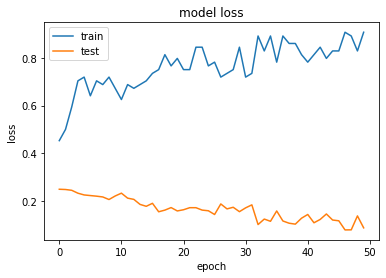

In [24]:
for project in list_project_names:
  project_name = project[0]
  time_split = project[1]

  # Model params
  steps_per_epoch = project[2]
  epochs = project[3]
  batch_size = project[4]

  # Load dataset
  df, graph = load_project(project_name)

  # Split data
  createds, updateds = get_time_features(df)
  train_nodes, test_nodes, all_nodes = split_data(createds, graph, time_split)

  # Pairing
  print('Pairing data!')
  train_pairs, train_labels = get_pairs(graph, train_nodes, train_nodes)
  test_pairs, test_labels = get_pairs(graph, test_nodes, all_nodes)

  # Get features
  # textual_features = list_chosen_textual_features[0]
  # add_feature = 3
  for textual_features in list_chosen_textual_features:
    for add_feature in list_add_features:
      all_textual_vectors = get_textual_features(df, textual_features)
      value_maxlen = all_textual_vectors.shape[1]
      
      # Model  
      if add_feature!=None:    
        links_train, non_links_train, link_other_features, non_link_other_features = get_separated_data_pairs([train_pairs, train_labels, createds, updateds], add_feature)
        train_other_features = np.concatenate([link_other_features, non_link_other_features])
        mean = np.mean(train_other_features)
        std = np.std(train_other_features)
        link_other_features = np.array([(link_other_features[i]-mean)/std for i in range(0, len(links_train))])
        non_link_other_features = np.array([(non_link_other_features[i]-mean)/std for i in range(0, len(non_links_train))])
        data_test, labels_test, other_features = get_test_data([test_pairs, test_labels, createds, updateds], add_feature)
        other_features = np.array([(other_features[i]-mean)/std for i in range(0, len(other_features))])
      else:
        links_train, non_links_train = get_separated_data_pairs([train_pairs, train_labels, createds, updateds], add_feature)
        data_test, labels_test = get_test_data([test_pairs, test_labels, createds, updateds], add_feature)

      if add_feature!=None:
        del train_other_features
        gc.collect() 

      result_path = '{}_Test_Fasttext_GRU_Post_1.txt'.format(project_name)
      param, lr, l = 256, 1e-3, 'mse'
      f = open(result_path, "a")
      listToStr = ' '.join([str(elem) for elem in textual_features]) 
      listToStr = listToStr + ' ' + repr(add_feature)
      f.write(listToStr)
      f.write('\n')
      if add_feature!=None:
        f.write('\n')
        f.write('mean = ' + repr(mean) + '\n')
        f.write('std = ' + repr(std) + '\n')
      f.close()

      model = return_model([value_maxlen, param, lr, l], add_feature)

      # Train model
      model_path = project_name + '_Fasttext_GRU_' + str(param) + str(lr) + str(l) + '.h5'
      print('Training model...')
      if add_feature == None:
        history = train_model([steps_per_epoch, epochs, batch_size, add_feature], [model_path, value_maxlen, model, all_textual_vectors], [links_train, non_links_train, None, None])
      else:
        history = train_model([steps_per_epoch, epochs, batch_size, add_feature], [model_path, value_maxlen, model, all_textual_vectors], [links_train, non_links_train, link_other_features, non_link_other_features])

      # summarize history for accuracy
      plt.plot(history.history['categorical_accuracy'])
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      plt.savefig(project_name + "_Fasttext_GRU_" + str(param) + str(l) + "_accuracy.png", dpi=1200)

      # summarize history for loss
      plt.plot(history.history['loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      plt.savefig(project_name + "_Fasttext_GRU_" + str(param) + str(l) + "_loss.png", dpi=1200)

      # Test model
      if add_feature!=None:
        y_s, pred_s, pred_proba = model_predict([value_maxlen, model, all_textual_vectors], data_test, labels_test, other_features)
      else:
        y_s, pred_s, pred_proba = model_predict([value_maxlen, model, all_textual_vectors], data_test, labels_test, None)
      evaluate(y_s, pred_s)
      get_result(project_name, result_path, [createds, test_nodes, all_nodes, test_pairs, pred_proba])
      np.savez(project_name + '_Fasttext_GRU_' + str(param) + "y", y_s = y_s, pred_s = pred_s, pred_proba = pred_proba)

      del y_s
      del pred_s
      del model
      gc.collect()